# **What Makes F1 Circuits Truly Different? A Data Dive Into Unexpected Similarities**

The data was manually compiled using information from multiple sources.

* https://www.formula1.com/en/latest/article/highs-and-lows-which-f1-track-has-the-most-elevation-changes-.7I9JEcBw3R2AqXbnJ6hyvc
* https://f1chronicle.com/formula-1-circuit-maps/#Las-Vegas-Strip-Circuit
* https://en.wikipedia.org/wiki/List_of_Formula_One_circuits
* https://www.formula1.com/en/results/2024/fastest-laps

In [1]:
import pandas as pd

df = pd.read_csv("F1_Circuits.csv")
df.head()

,Circuit Name,Grand Prix,Track Length (km),Turns,Type,Fastest Lap Time (2024),Low Speed Corners,Medium Speed Corners,High Speed Corners,Elevation Change (m),Straights,DRS Zones,Humidity,Time of Day,Temperature
0,Bahrain International Circuit,Bahrain,5.412,15,Race circuit,01:32.6,3,6,6,16.9,High,3,Low-Moderate,Night,High
1,Jeddah Corniche Circuit,Saudi Arabia,6.174,27,Street circuit,01:31.6,3,5,19,2.8,High,3,Moderate-High,Night,High
2,Albert Park Circuit,Australia,5.278,14,Street circuit,01:19.8,3,3,8,2.6,Medium,4,Moderate,Day,Moderate
3,Suzuka International Racing Course,Japan,5.807,18,Race circuit,01:33.7,3,4,11,40.4,Medium,1,Moderate,Day,Moderate
4,Shanghai International Circuit,China,5.451,16,Race circuit,01:37.8,5,5,6,7.4,High,2,Moderate,Day,Moderate


We convert lap times from MM:SS.sss format to seconds and calculate the average speed for each circuit using track length and fastest lap time.

In [2]:
def lap_time_to_seconds(lap_time):
    minutes = int(lap_time[:2])
    seconds = float(lap_time[3:])
    return minutes * 60 + seconds

df["Fatest Lap Time (s)"] = df["Fastest Lap Time (2024)"].apply(lap_time_to_seconds)
df["Average Speed (km/h)"] = (df["Track Length (km)"] / (df["Fatest Lap Time (s)"] / 3600)).round(2)

df.head()

,Circuit Name,Grand Prix,Track Length (km),Turns,Type,Fastest Lap Time (2024),Low Speed Corners,Medium Speed Corners,High Speed Corners,Elevation Change (m),Straights,DRS Zones,Humidity,Time of Day,Temperature,Fatest Lap Time (s),Average Speed (km/h)
0,Bahrain International Circuit,Bahrain,5.412,15,Race circuit,01:32.6,3,6,6,16.9,High,3,Low-Moderate,Night,High,92.6,210.40
1,Jeddah Corniche Circuit,Saudi Arabia,6.174,27,Street circuit,01:31.6,3,5,19,2.8,High,3,Moderate-High,Night,High,91.6,242.65
2,Albert Park Circuit,Australia,5.278,14,Street circuit,01:19.8,3,3,8,2.6,Medium,4,Moderate,Day,Moderate,79.8,238.11
3,Suzuka International Racing Course,Japan,5.807,18,Race circuit,01:33.7,3,4,11,40.4,Medium,1,Moderate,Day,Moderate,93.7,223.11
4,Shanghai International Circuit,China,5.451,16,Race circuit,01:37.8,5,5,6,7.4,High,2,Moderate,Day,Moderate,97.8,200.65


We convert categorical features into numerical format for clustering, so we use one-hot encoding.

In [3]:
df_encoded = pd.get_dummies(df, columns=['Straights','Humidity', 'Time of Day', 'Temperature', 'Type'])


We scale the features and use the Elbow Method to identify the optimal number of clusters by plotting the KMeans inertia for values of K from 1 to 15.

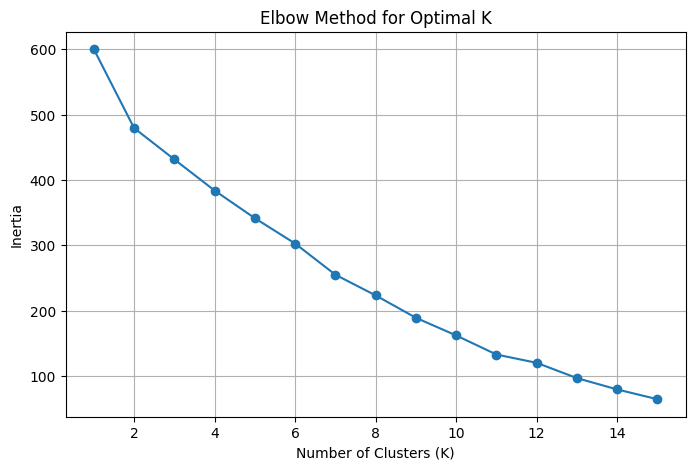

In [4]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Scaling
drop_cols = ['Circuit Name', 'Grand Prix', 'Fastest Lap Time (2024)', 'Fastest Lap Time (s)']
X = df_encoded.drop(columns=drop_cols, errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to find optimal K
inertia = []
k_range = range(1, 16)  # K from 1 to 1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


We apply KMeans clustering with K=5, reduce the data to 3 principal components using PCA, and visualize the circuit clusters in 3D while also showing the explained variance for each component.

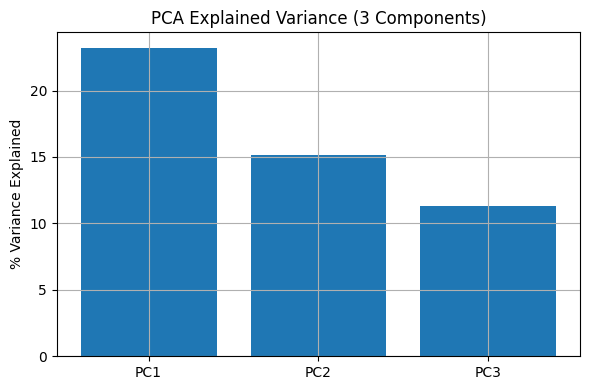

Cumulative variance (3 components): 0.50


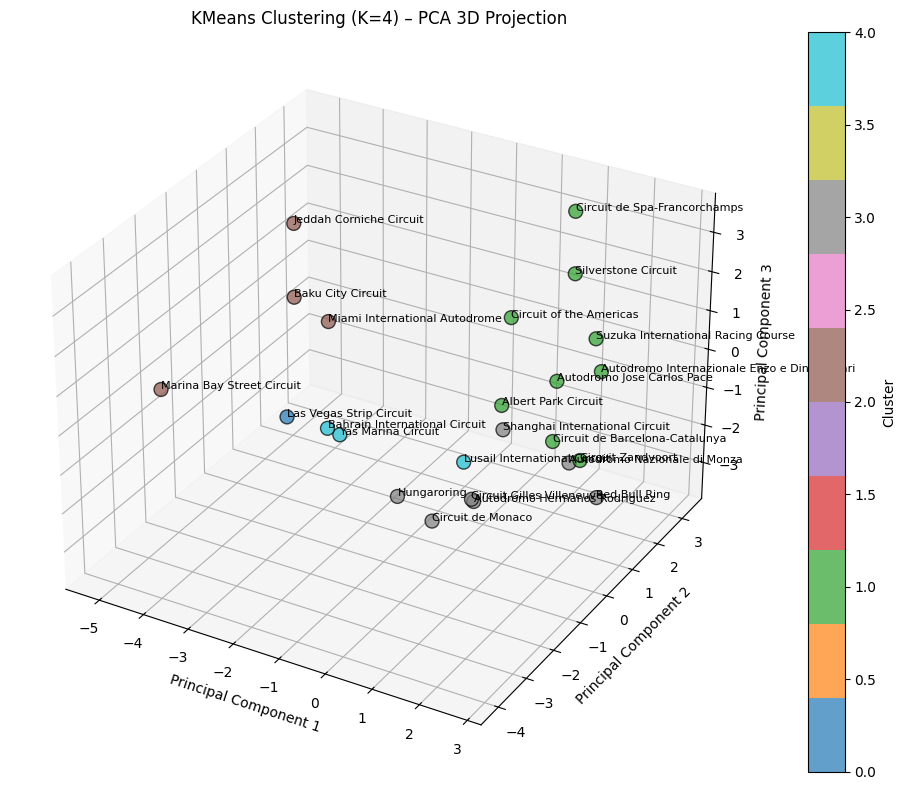

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

np.random.seed(42)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering with K = 5
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded['Cluster'] = kmeans.fit_predict(X_scaled)

# PCA with n = 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6, 4))
plt.bar(['PC1', 'PC2', 'PC3'], pca.explained_variance_ratio_ * 100)
plt.ylabel('% Variance Explained')
plt.title('PCA Explained Variance (3 Components)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Cumulative variance (3 components): {np.sum(pca.explained_variance_ratio_):.2f}")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=df_encoded['Cluster'], cmap='tab10', s=100, edgecolor='k', alpha=0.7)

# Annotate circuit names
for i, name in enumerate(df_encoded['Circuit Name']):
    ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], name, fontsize=8)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('KMeans Clustering (K=4) – PCA 3D Projection')

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

* Cluster 0 (Brown): Miami International Autodrome, Jeddah Street Circuit, Baku City Circuit, Marina Bay Street Circuit
* Cluster 1 (Grey): Hungaroring, Circuit de Monaco, Red Bull Ring, Autódromo Hermanos Rodríguez, Circuit Gilles Villeneuve, Shanghai International Circuit, Autodromo Nazionale di Monza
* Cluster 2 (Dark Blue): Las Vegas Street Circuit
* Cluster 3 (Light Blue): Lusail International Circuit, Yas Marina Circuit, Bahrain International Circuit
* Cluster 4 (Green): Circuit de Spa-Francorchamps, Silverstone Circuit, Circuit of the Americas, Circuit de Barcelona-Catalunya, Albert Park Circuit, Circuit Zandvoort, Suzuka International Racing Course, Autodromo Internazionale Enzo e Dino Ferrari, Interlagos (Autódromo José Carlos Pace)

This classification lacks accuracy because it mixes circuits with fundamentally different characteristics, leading to incoherent groupings. High-speed power tracks like Monza and Red Bull Ring are clustered with tight, technical layouts like Monaco and Hungaroring, which demand entirely different car setups and strategies. Similarly, Las Vegas is incorrectly isolated, despite sharing features with other night races like Yas Marina and Bahrain. Meanwhile, forgiving layouts like Miami are grouped with punishing street circuits such as Baku and Jeddah, overlooking key differences in track width, grip, and race dynamics.

We compute the cosine similarity between circuits based on their scaled features and visualize the pairwise similarity as a heatmap for easier comparison.

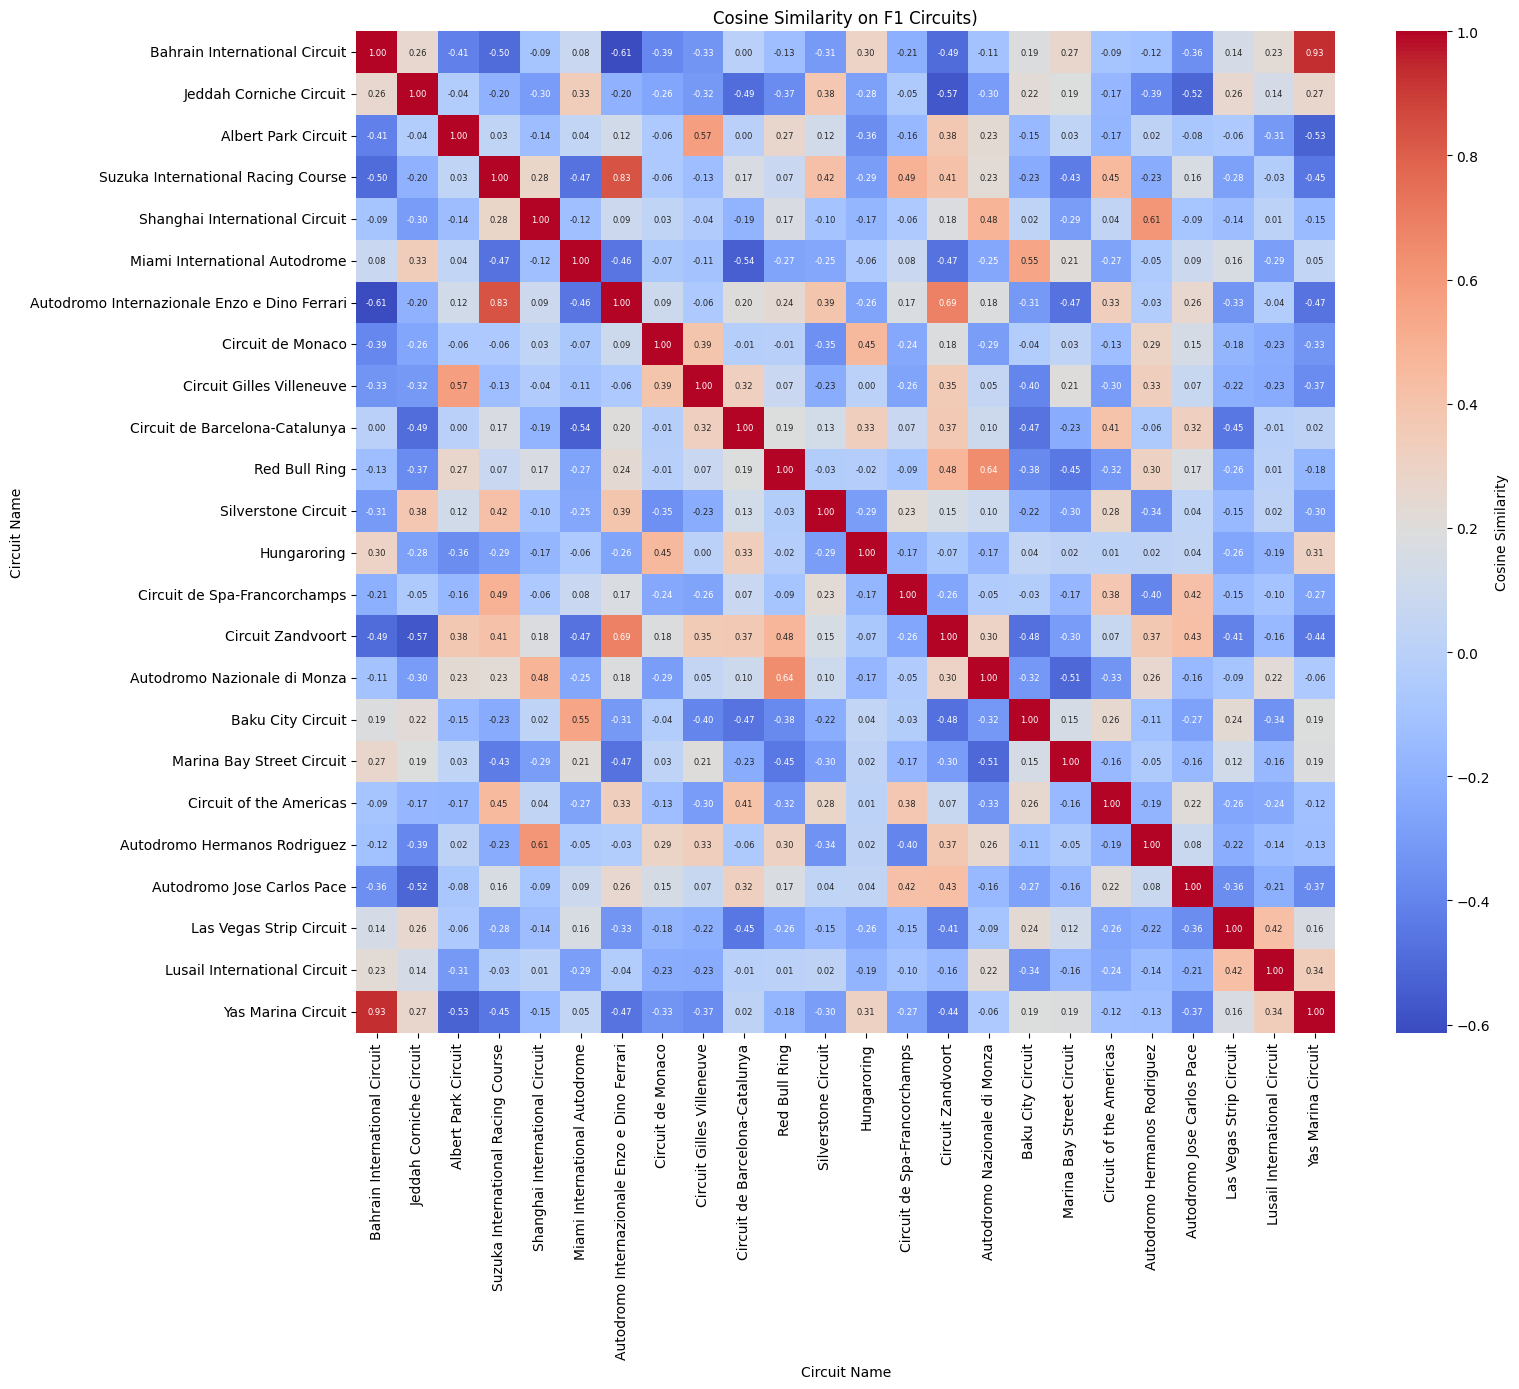

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cosine Similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X_scaled)

# Heatmap
similarity_df = pd.DataFrame(similarity_matrix, index=df['Circuit Name'], columns=df['Circuit Name'])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))
sns.heatmap(similarity_df, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=True, yticklabels=True,
            annot_kws={"size": 6}, cbar_kws={"label": "Cosine Similarity"})
plt.title("Cosine Similarity on F1 Circuits)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Most Similar Circuits:
* Yas Marina Circuit - Bahrain International Circuit (0.93)
* Autodromo Internazionale Enzo e Dino Ferrari - Suzuka International Racing Course (0.83)
* Circuit Zandvoort - Autodromo Internazionale Enzo e Dino Ferrari (0.69)
* Autodromo Nazionale di Monza - Red Bull Ring (0.64)

We apply spherical KMeans clustering (by L2-normalizing the features before clustering) with K=5 to better capture directional similarity between circuits, then reduce the dimensions using PCA and visualize the resulting clusters in 3D, along with how much variance each principal component explains.

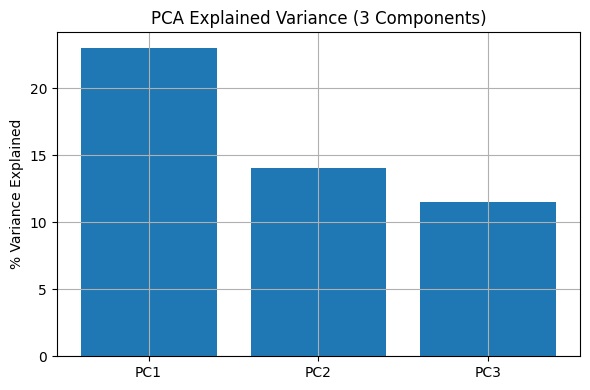

Cumulative variance (3 components): 0.49


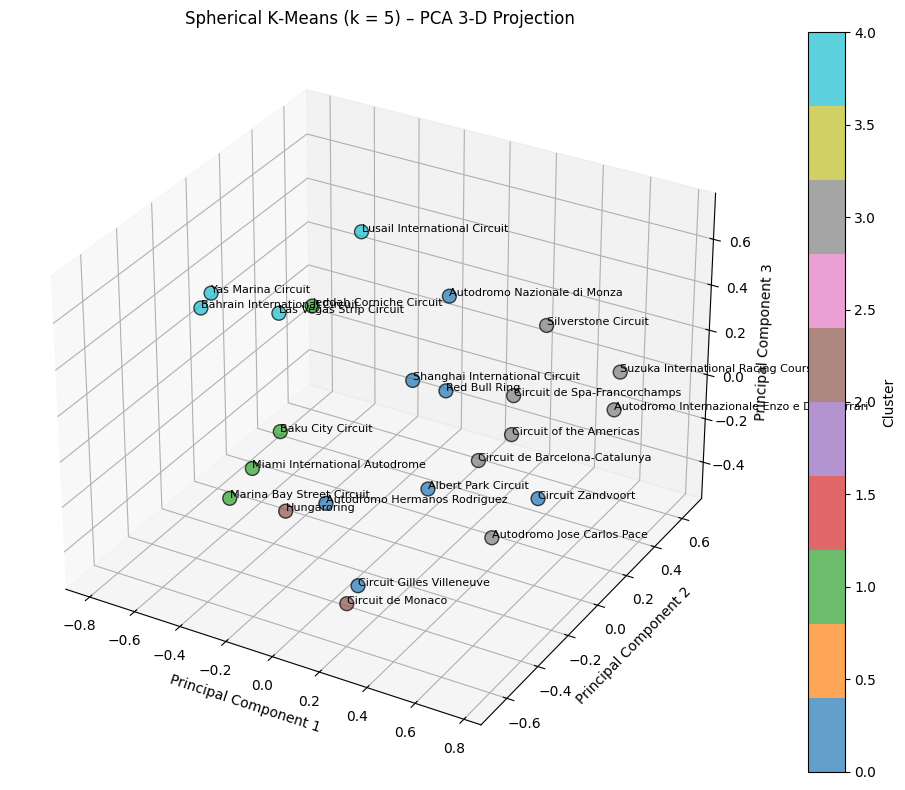

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

np.random.seed(42)

scaler = StandardScaler()
X_std   = scaler.fit_transform(X)
X_unit  = normalize(X_std, norm='l2')

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df_encoded['Cluster'] = kmeans.fit_predict(X_unit)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_unit)

plt.figure(figsize=(6, 4))
plt.bar(['PC1', 'PC2', 'PC3'], pca.explained_variance_ratio_ * 100)
plt.ylabel('% Variance Explained')
plt.title('PCA Explained Variance (3 Components)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Cumulative variance (3 components): {np.sum(pca.explained_variance_ratio_):.2f}")

fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=df_encoded['Cluster'], cmap='tab10',
    s=100, edgecolor='k', alpha=0.7
)

for i, name in enumerate(df_encoded['Circuit Name']):
    ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], name, fontsize=8)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Spherical K‑Means (k = 5) – PCA 3‑D Projection')

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

The explained variance from PCA is 0.49, meaning the 3D projection captures about 49% of the total information, enough to reveal broad clustering structure, though some details may be lost due to dimensionality reduction.

* Cluster 0 (Cyan): Lusail International Circuit, Yas Marina Circuit, Las Vegas Street Circuit, Bahrain International Circuit
* Cluster 1 (Green): Jeddah Street Circuit, Baku City Circuit, Marina Bay Street Circuit, Miami International Autodrome
* Cluster 2 (Brown): Hungaroring, Circuit de Monaco
* Cluster 3 (Grey): Circuit of the Americas, Circuit de Barcelona-Catalunya, Circuit de Spa-Francorchamps, Silverstone Circuit, Suzuka International Racing Course, Autodromo Internazionale Enzo e Dino Ferrari, Autódromo José Carlos Pace
* Cluster 4 (Cobalt Blue): Red Bull Ring, Autódromo Hermanos Rodríguez, Circuit Gilles Villeneuve, Albert Park Circuit, Circuit Zandvoort, Shanghai International Circuit, Autodromo Nazionale di Monza

This classification provides a more consistent and analytically sound clustering by grouping circuits with similar layout types, speed profiles, and strategic demands. Tracks dependent on straight-line speed and low-drag setups are grouped together, while technical circuits reliant on downforce and precision driving are clearly separated. It also accurately identifies outliers within clusters without over-segmenting. Overall, Set 2 better reflects how teams and drivers approach each circuit, making it the more reliable and insightful classification.

We combine qualifying, race, driver, constructor, and circuit data from 2022 to 2024 for all races on the 2024 calendar, creating a combined dataset of driver performance (qualifying, grid, and finish positions).
* https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download&select=races.csv

In [8]:
import pandas as pd

# Load uploaded CSV files
drivers = pd.read_csv("drivers.csv")
constructors = pd.read_csv("constructors.csv")
results = pd.read_csv("results.csv")
qualifying = pd.read_csv("qualifying.csv")
races = pd.read_csv("races.csv")

# Rename columns to avoid name conflicts during merging
constructors = constructors.rename(columns={'name': 'TeamName'})
races = races.rename(columns={'name': 'Circuit'})

# List of circuits on 2024 calendar
circuits_2024 = [
    "Bahrain Grand Prix", "Saudi Arabian Grand Prix", "Australian Grand Prix", "Japanese Grand Prix",
    "Chinese Grand Prix", "Miami Grand Prix", "Emilia Romagna Grand Prix", "Monaco Grand Prix",
    "Canadian Grand Prix", "Spanish Grand Prix", "Austrian Grand Prix", "British Grand Prix",
    "Hungarian Grand Prix", "Belgian Grand Prix", "Dutch Grand Prix", "Italian Grand Prix",
    "Azerbaijan Grand Prix", "Singapore Grand Prix", "United States Grand Prix", "Mexican Grand Prix",
    "São Paulo Grand Prix", "Las Vegas Grand Prix", "Qatar Grand Prix", "Abu Dhabi Grand Prix"
]

# Filter for 2022–2024 races held on 2024 circuits
filtered_races = races[(races['year'].isin([2022, 2023, 2024])) & (races['Circuit'].isin(circuits_2024))]

# Qualifying data
q = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'QualiPosition'})
# Race data
r = results[['raceId', 'driverId', 'constructorId', 'grid', 'position']].rename(
    columns={'grid': 'GridPosition', 'position': 'FinishPosition'})
# Combine
merged = filtered_races.merge(q, on='raceId', how='left')
merged = merged.merge(r, on=['raceId', 'driverId'], how='left')
merged = merged.merge(drivers[['driverId', 'forename', 'surname']], on='driverId', how='left')
merged = merged.merge(constructors[['constructorId', 'TeamName']], on='constructorId', how='left')
merged['Driver'] = merged['forename'] + ' ' + merged['surname']
final_df = merged[['year', 'Circuit', 'Driver', 'TeamName', 'QualiPosition', 'GridPosition', 'FinishPosition']]

final_df.to_csv("quali-race.csv")

final_df

,year,Circuit,Driver,TeamName,QualiPosition,GridPosition,FinishPosition
0,2022,Bahrain Grand Prix,Charles Leclerc,Ferrari,1,1,1
1,2022,Bahrain Grand Prix,Max Verstappen,Red Bull,2,2,19
2,2022,Bahrain Grand Prix,Carlos Sainz,Ferrari,3,3,2
3,2022,Bahrain Grand Prix,Sergio Pérez,Red Bull,4,4,18
4,2022,Bahrain Grand Prix,Lewis Hamilton,Mercedes,5,5,3
...,...,...,...,...,...,...,...
1274,2024,Abu Dhabi Grand Prix,Alexander Albon,Williams,16,18,11
1275,2024,Abu Dhabi Grand Prix,Guanyu Zhou,Sauber,17,15,13
1276,2024,Abu Dhabi Grand Prix,Lewis Hamilton,Mercedes,18,16,4
1277,2024,Abu Dhabi Grand Prix,Franco Colapinto,Williams,19,20,\N


We calculate the average qualifying and finishing positions for each driver at every circuit by grouping the merged race data, ensuring numerical conversion and rounding the results for clarity.

In [9]:
final_df = pd.read_csv("quali-race.csv")

final_df['QualiPosition'] = pd.to_numeric(final_df['QualiPosition'], errors='coerce')
final_df['FinishPosition'] = pd.to_numeric(final_df['FinishPosition'], errors='coerce')
driver_circuit_avg = final_df.groupby(['Circuit', 'Driver'])[['QualiPosition', 'FinishPosition']].mean().reset_index()
driver_circuit_avg = driver_circuit_avg.round(2)

driver_circuit_avg

,Circuit,Driver,QualiPosition,FinishPosition
0,Abu Dhabi Grand Prix,Alexander Albon,16.33,12.67
1,Abu Dhabi Grand Prix,Carlos Sainz,7.67,8.00
2,Abu Dhabi Grand Prix,Charles Leclerc,6.33,2.33
3,Abu Dhabi Grand Prix,Daniel Ricciardo,12.50,10.00
4,Abu Dhabi Grand Prix,Esteban Ocon,10.00,9.50
...,...,...,...,...
544,United States Grand Prix,Pierre Gasly,9.00,10.67
545,United States Grand Prix,Sebastian Vettel,12.00,8.00
546,United States Grand Prix,Sergio Pérez,7.67,5.00
547,United States Grand Prix,Valtteri Bottas,13.67,14.50


We calculate the average qualifying and finishing positions for each team at every circuit by grouping the cleaned race data, converting positions to numeric, and rounding the results for clarity.

In [10]:
final_df = pd.read_csv("quali-race.csv")

final_df['QualiPosition'] = pd.to_numeric(final_df['QualiPosition'], errors='coerce')
final_df['FinishPosition'] = pd.to_numeric(final_df['FinishPosition'], errors='coerce')
team_circuit_avg = final_df.groupby(['Circuit', 'TeamName'])[['QualiPosition', 'FinishPosition']].mean().reset_index()
team_circuit_avg = team_circuit_avg.round(2)

team_circuit_avg

,Circuit,TeamName,QualiPosition,FinishPosition
0,Abu Dhabi Grand Prix,Alfa Romeo,17.50,15.75
1,Abu Dhabi Grand Prix,AlphaTauri,12.50,11.00
2,Abu Dhabi Grand Prix,Alpine F1 Team,11.17,10.80
3,Abu Dhabi Grand Prix,Aston Martin,10.67,9.67
4,Abu Dhabi Grand Prix,Ferrari,7.00,5.17
...,...,...,...,...
269,United States Grand Prix,Mercedes,7.33,4.50
270,United States Grand Prix,RB F1 Team,13.00,11.50
271,United States Grand Prix,Red Bull,5.67,3.33
272,United States Grand Prix,Sauber,19.00,18.00


We create a heatmap to visualize the average finishing positions of each driver across different circuits, helping identify patterns in driver performance.

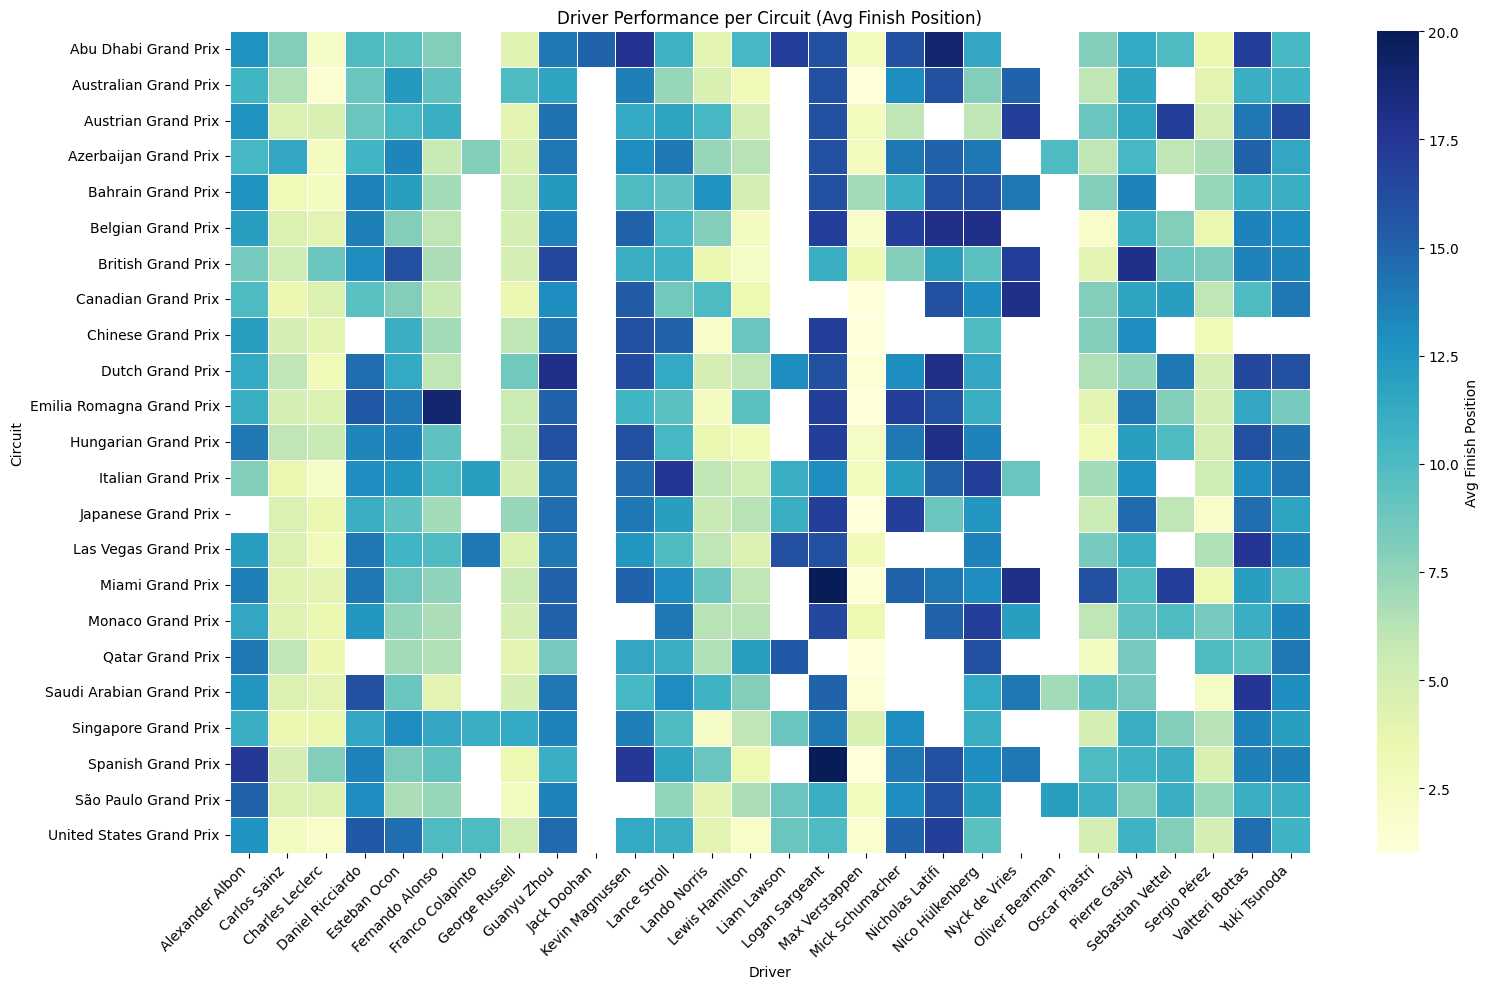

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

driver_pivot = driver_circuit_avg.pivot(index='Circuit', columns='Driver', values='FinishPosition')

plt.figure(figsize=(16, 10))
sns.heatmap(driver_pivot, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Avg Finish Position'}, linewidths=0.5)
plt.title("Driver Performance per Circuit (Avg Finish Position)")
plt.xlabel("Driver")
plt.ylabel("Circuit")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


We create a heatmap to visualize the average finishing positions of each team at every circuit, making it easier to compare team performance.

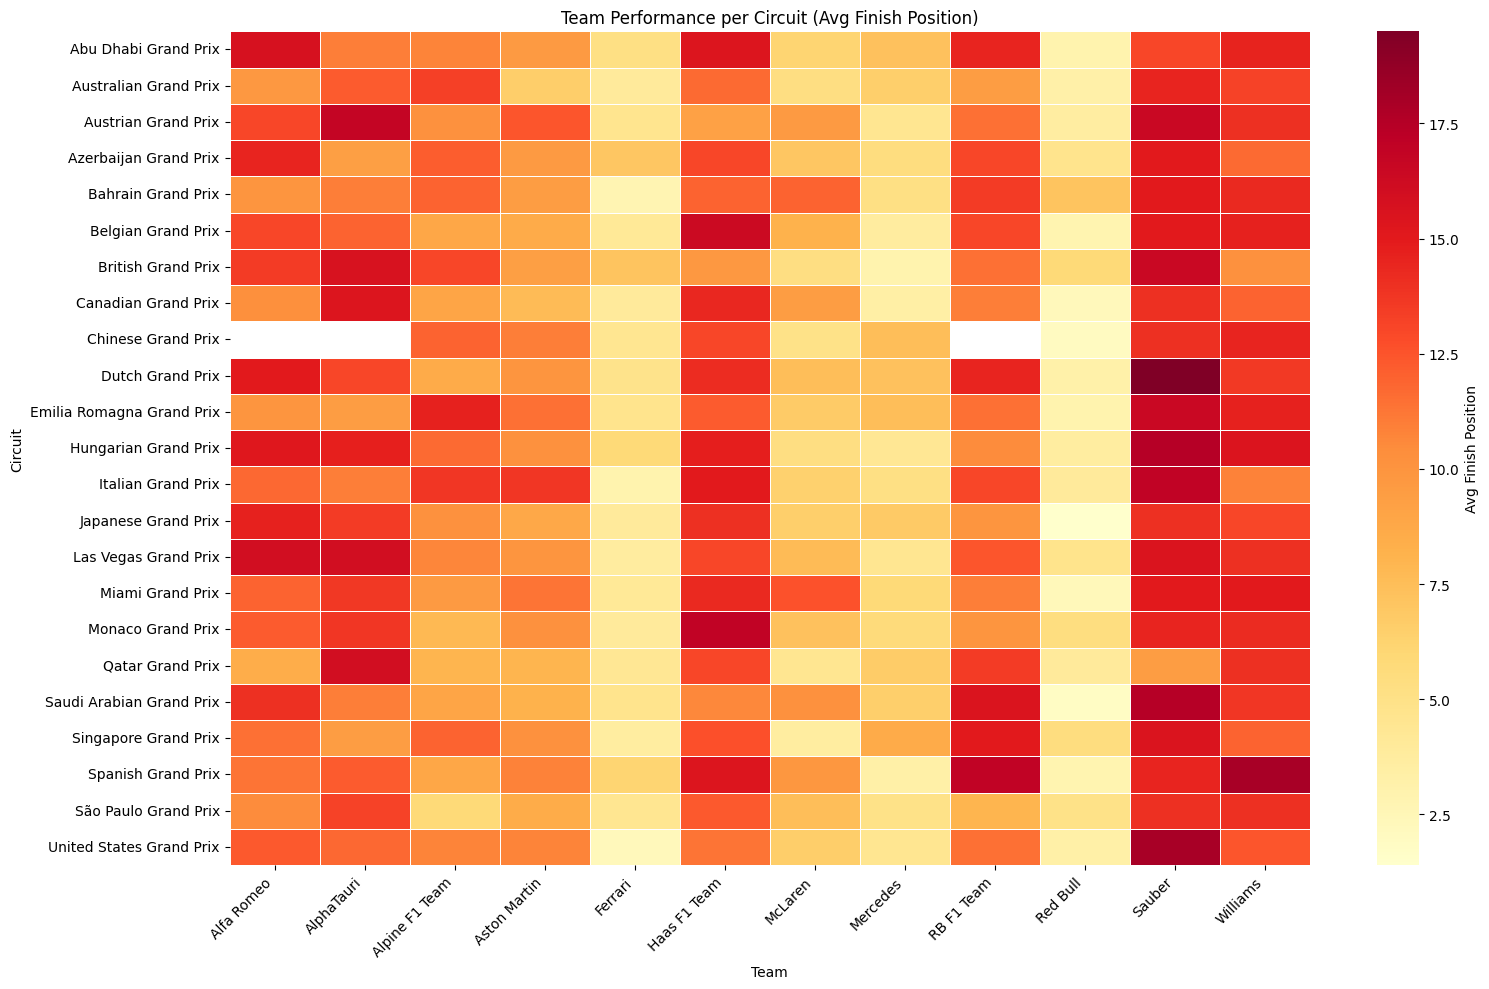

In [12]:
team_pivot = team_circuit_avg.pivot(index='Circuit', columns='TeamName', values='FinishPosition')

plt.figure(figsize=(16, 10))
sns.heatmap(team_pivot, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Avg Finish Position'}, linewidths=0.5)
plt.title("Team Performance per Circuit (Avg Finish Position)")
plt.xlabel("Team")
plt.ylabel("Circuit")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We map each Grand Prix to its respective cluster, standardize team names, calculate the average finishing position per team within each cluster, and visualize the results.

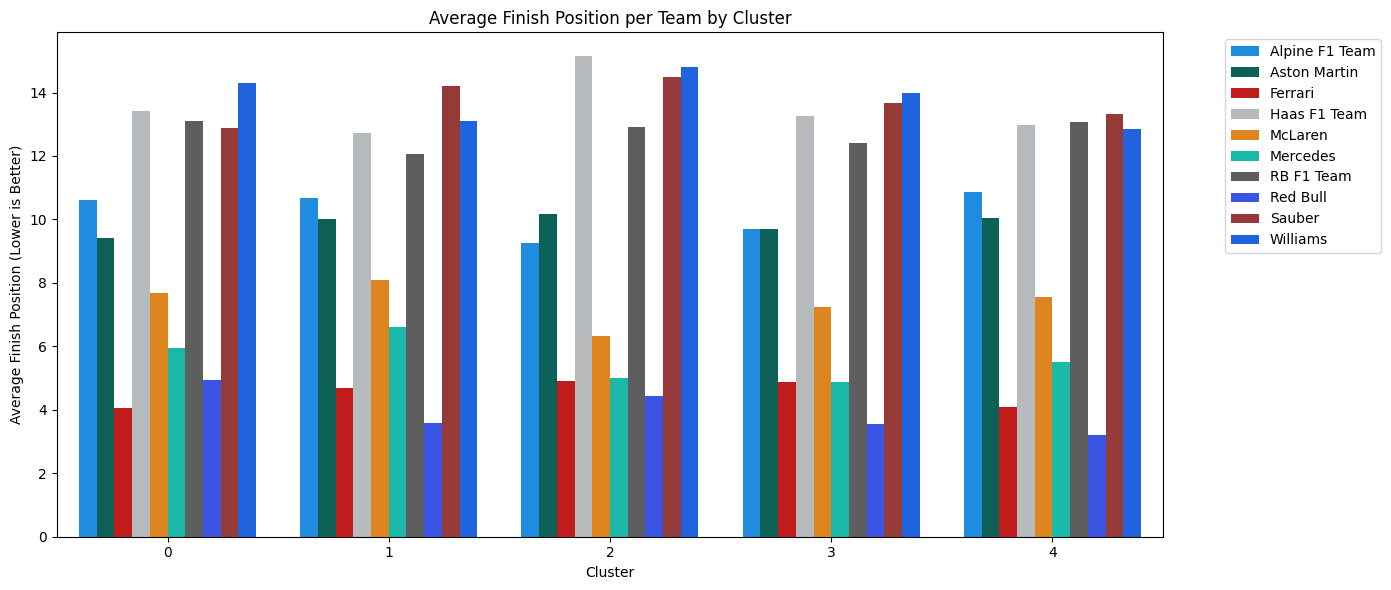

In [14]:
# Map each circuit to a cluster
circuit_cluster_map = {
    # Cluster 0 (Cyan)
    "Qatar Grand Prix": 0,
    "Abu Dhabi Grand Prix": 0,
    "Las Vegas Grand Prix": 0,
    "Bahrain Grand Prix": 0,

    # Cluster 1 (Green)
    "Saudi Arabian Grand Prix": 1,
    "Azerbaijan Grand Prix": 1,
    "Singapore Grand Prix": 1,
    "Miami Grand Prix": 1,

    # Cluster 2 (Brown)
    "Hungarian Grand Prix": 2,
    "Monaco Grand Prix": 2,

    # Cluster 3 (Grey)
    "United States Grand Prix": 3,
    "Spanish Grand Prix": 3,
    "Belgian Grand Prix": 3,
    "British Grand Prix": 3,
    "Japanese Grand Prix": 3,
    "Emilia Romagna Grand Prix": 3,
    "São Paulo Grand Prix": 3,

    # Cluster 4 (Cobalt Blue)
    "Austrian Grand Prix": 4,
    "Mexican Grand Prix": 4,
    "Canadian Grand Prix": 4,
    "Australian Grand Prix": 4,
    "Dutch Grand Prix": 4,
    "Chinese Grand Prix": 4,
    "Italian Grand Prix": 4
}

# Standardize team names to account for name changes
team_name_map = {
    "AlphaTauri": "RB F1 Team",
    "Alfa Romeo": "Sauber",
}

final_df['TeamName'] = final_df['TeamName'].replace(team_name_map)

final_df['Cluster'] = final_df['Circuit'].map(circuit_cluster_map)

clustered_df = final_df.dropna(subset=['Cluster'])

team_cluster_avg = clustered_df.groupby(['Cluster', 'TeamName'])['FinishPosition'].mean().reset_index()
team_cluster_avg = team_cluster_avg.round(2)

team_cluster_avg

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
team_colors = {
    "Red Bull": "#1E41FF",
    "Ferrari": "#DC0000",
    "Mercedes": "#00D2BE",
    "McLaren": "#FF8700",
    "Alpine F1 Team": "#0090FF",
    "Aston Martin": "#006F62",
    "AlphaTauri": "#2B4562",
    "Williams": "#005AFF",
    "Haas F1 Team": "#B6BABD",
    "Alfa Romeo": "#900000",
    "RB F1 Team": "#5E5E5E",
    "Sauber": "#A52A2A"
}

palette = [team_colors[t] for t in team_cluster_avg['TeamName'].unique()]

sns.barplot(
    data=team_cluster_avg,
    x='Cluster',
    y='FinishPosition',
    hue='TeamName',
    palette=palette
)
plt.title("Average Finish Position per Team by Cluster")
plt.ylabel("Average Finish Position (Lower is Better)")
plt.xlabel("Cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

We map each Grand Prix to its respective cluster, standardize team names, calculate the average qualifying position per team within each cluster, and visualize the results.

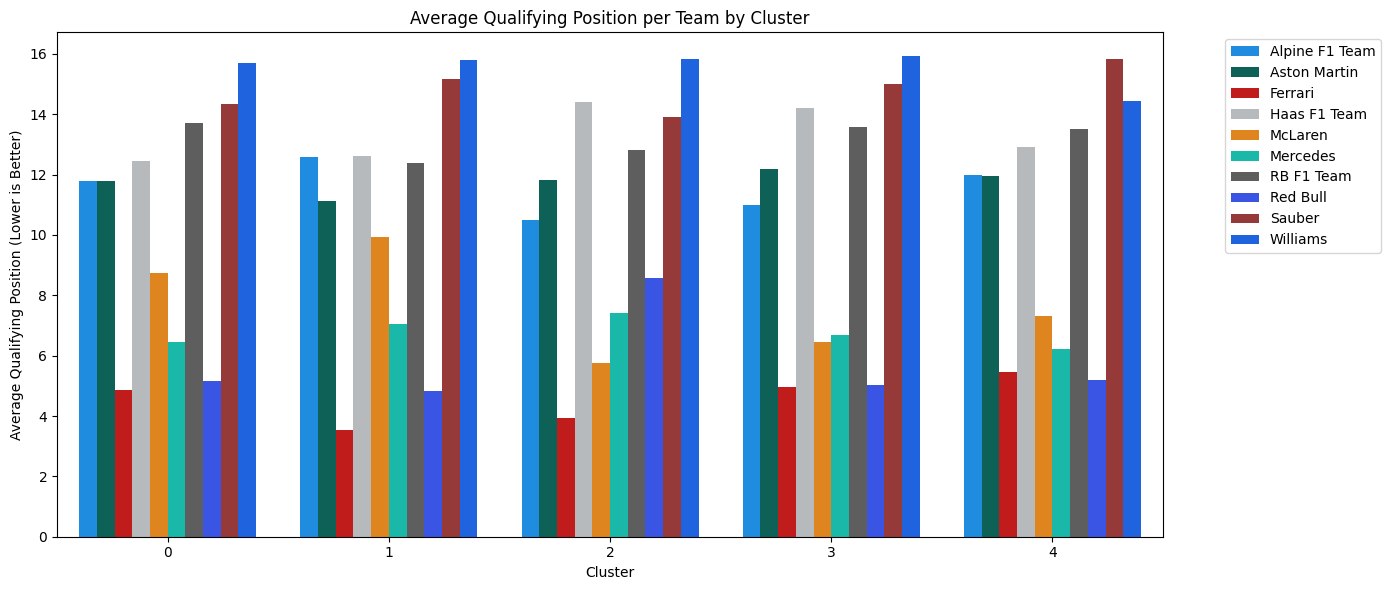

In [15]:
team_cluster_avg_quali = clustered_df.groupby(['Cluster', 'TeamName'])['QualiPosition'].mean().reset_index()
team_cluster_avg_quali = team_cluster_avg_quali.round(2)

plt.figure(figsize=(14, 6))

palette_quali = [team_colors[t] for t in team_cluster_avg_quali['TeamName'].unique()]

sns.barplot(
    data=team_cluster_avg_quali,
    x='Cluster',
    y='QualiPosition',
    hue='TeamName',
    palette=palette_quali
)
plt.title("Average Qualifying Position per Team by Cluster")
plt.ylabel("Average Qualifying Position (Lower is Better)")
plt.xlabel("Cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

We map each Grand Prix to its respective cluster, standardize team names, calculate the average position change (qualifying to race) per team within each cluster, and visualize the results.

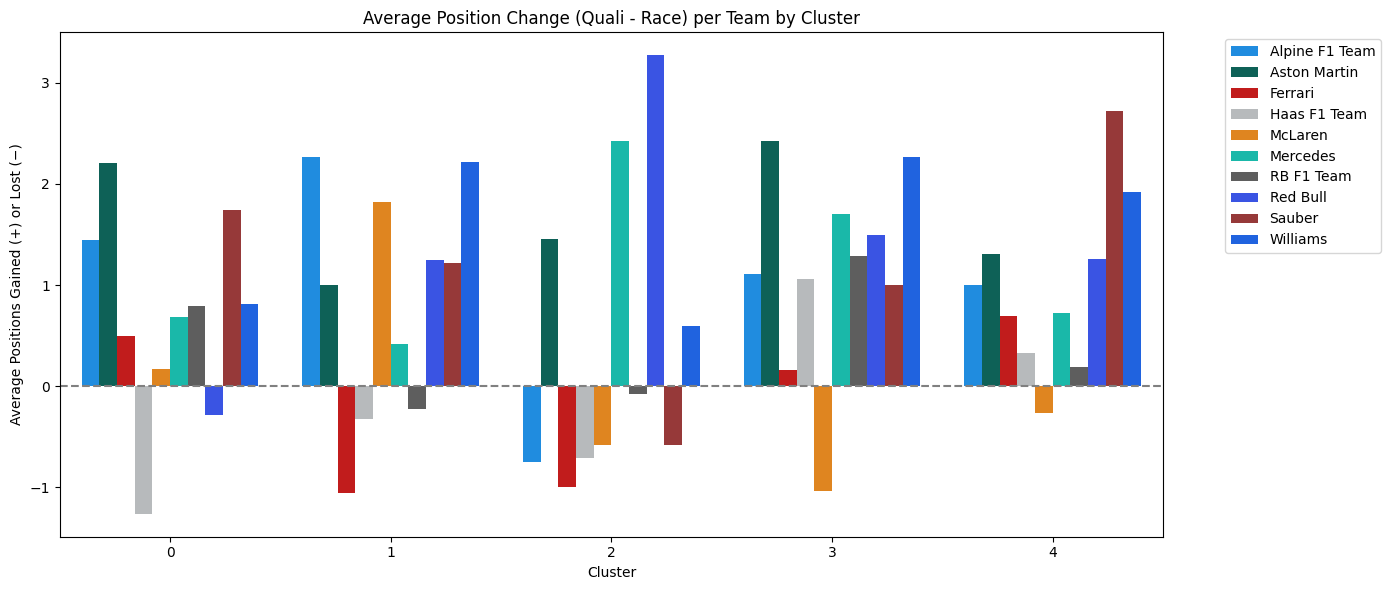

In [16]:
clustered_df['QualiPosition'] = pd.to_numeric(clustered_df['QualiPosition'], errors='coerce')
clustered_df['FinishPosition'] = pd.to_numeric(clustered_df['FinishPosition'], errors='coerce')

clustered_df['PositionChange'] = clustered_df['QualiPosition'] - clustered_df['FinishPosition']

team_cluster_change = clustered_df.groupby(['Cluster', 'TeamName'])['PositionChange'].mean().reset_index()
team_cluster_change = team_cluster_change.round(2)

plt.figure(figsize=(14, 6))

palette_change = [team_colors[t] for t in team_cluster_change['TeamName'].unique()]

sns.barplot(
    data=team_cluster_change,
    x='Cluster',
    y='PositionChange',
    hue='TeamName',
    palette=palette_change
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Average Position Change (Quali - Race) per Team by Cluster")
plt.ylabel("Average Positions Gained (+) or Lost (−)")
plt.xlabel("Cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()